In [1]:
import numpy as np 
import pandas as pd 
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import sys

def next_state(state, action, action_level):
    next_state = state.copy()
    if (action > 2*action_level) or action < 0:
        print("action = ", action)
        sys.exit("error, action undefined! nxt")

    if action >= 1 and action <= action_level:
        # then buy
        
        if state['HandCash'] > 0:
            next_state['HandCash'] = state['HandCash']*(1 - action/action_level)
            next_state['NumStock'] = state['NumStock'] + \
                                     (state['HandCash']/state['StockPrice'])*(action/action_level)

    elif action >= (action_level + 1) and action <= (action_level + action_level) :
        # then sell
        
        if state['NumStock'] > 0:
            next_state['NumStock'] = state['NumStock']*(1 - (action-action_level)/action_level)
            next_state['HandCash'] = state['HandCash'] + \
                                     (state['StockPrice']*state['NumStock'])*((action-action_level)/action_level)
    
    return next_state


def reward(state, init_invest):
    return (state['NumStock']*state['StockPrice'] + state['HandCash']) - init_invest

def my_reward(curr, last):
    return (curr['NumStock']*curr['StockPrice'] + curr['HandCash']) - \
           (last['NumStock']*last['StockPrice'] + last['HandCash'])

In [3]:
def feature_5_conti(k_today, d_today, k_yestd, d_yestd, action, action_level):
    inter = (k_yestd+d_yestd+k_today+d_today)/4
    sinter = inter/100 # scaled inter
    if((k_yestd > d_yestd and k_today < d_today and inter > 50) or \
       (k_yestd < d_yestd and k_today > d_today and inter < 50)):
        # saction= sell all:1, sell:1~0.5, hold:0.5, buy:0.5~0, buy all:0
        # the diff btw saction & sinter(i.e. inter/100) : smaller is better(then return larger value)
        
        if(action <= action_level):
            saction = (action_level - action)/(2*action_level) # scaled action
        else:
            saction = action/(2*action_level)
            
        return 1-abs(sinter-saction)
        
    else: # best to hold
        if(action <= action_level): # hold
            return (action_level - action)/float(action_level)
        elif(action_level < action <= 2*action_level):
            return (2*action_level - action)/float(action_level)
    

def feature_5_dis(k_today, d_today, k_yestd, d_yestd, action, action_level):
    inter = (k_yestd+d_yestd+k_today+d_today)/4
    if(k_yestd < d_yestd and k_today > d_today and inter <= 30): # buy
        if(action <= action_level):
            return (action + action_level)/float(2*action_level)
        elif(action_level < action <= 2*action_level):
            return (2*action_level - action)/float(2*action_level)
       
    elif(k_yestd > d_yestd and k_today < d_today and inter >= 70): # sell
        if(action <= action_level):
            return (action_level - action)/float(2*action_level)
        elif(action_level < action <= 2*action_level):
            return (action)/float(2*action_level)
    else:
        if(action <= action_level): # hold
            return (action_level - action)/float(action_level)
        elif(action_level < action <= 2*action_level):
            return (2*action_level - action)/float(action_level)
        
        
def feature_5_dis_all(k_today, d_today, k_yestd, d_yestd, action, action_level):
    
    inter = (k_yestd+d_yestd+k_today+d_today)/4
    
    if(k_yestd < d_yestd and k_today > d_today and inter <= 20): # buy
        if(action == action_level):
            return 1
        else:
            return 0
       
    elif(k_yestd > d_yestd and k_today < d_today and inter >= 80): # sell
        if(action == action_level+action_level):
            return 1
        else:
            return 0
        
    else:
        if(action == 0): # hold
            return 1
        else:
            return 0

In [4]:
from random import randint

def V_value(k_today, d_today, k_yestd, d_yestd, state, action_level):
    v = 0
    first = 1 # flag of the frist iteration
    v_act = ''
    for action in range(0, (2*action_level + 1)):
        
        # choose feature_5_conti or feature_5_dis here!!
        curr_q = feature_5_dis_all(k_today, d_today, k_yestd, d_yestd, action, action_level)
        
        if first == 1:
            first = 0
            v = curr_q
            v_act = action
        elif curr_q > v:
            v = curr_q
            v_act = action
        elif curr_q == v:
            flip = randint(0, 1)
            if flip == 1:
                v = curr_q
                v_act = action
        
    return [v, v_act]

##### lists of data in each folder: copy and paste into the cell below
* ../input/  
inputFolderFormat = "../input/{0}"
inputCsvList = ['QCOM.csv', 'GOOG.csv', 'NOK.csv', '^DJI.csv', '^TWII.csv', 
           '^N225.csv', '^GDAXI.csv', '^IXIC.csv', '^KS11.csv', '^SSEC.csv', 
           'NSU.DE_10_5_5.csv', 'DAI.DE_10_5_5.csv', 'BMW.DE_10_5_5.csv', 
           '0050.TW.csv', '1216.TW.csv', '1301.TW.csv', '2002.TW.csv', 
           '2330.TW.csv', '2409.TW.csv', '2454.TW.csv', '1704.TW.csv']

* ../input/2001_2010/  
inputFolderFormat = "../input/2001_2010/{0}"
inputCsvList = ['QCOM.csv', 'NOK.csv', '^DJI.csv', '^TWII.csv', 
            '^N225.csv', '^GDAXI.csv', '^IXIC.csv', '^KS11.csv', 
            '^SSEC.csv', 'NSU.DE.csv', 'DAI.DE.csv', 'BMW.DE.csv']  
* ../input/fall/  
inputFolderFormat = "../input/fall/{0}"  
inputCsvList = ['1314.TW.csv', '2323.TW.csv', '2349.TW.csv', 
'2353.TW.csv', '2405.TW.csv', '2409.TW.csv', '2601.TW.csv', 
'2885.TW.csv', '2888.TW.csv', '6116.TW.csv']

In [5]:
from random import randint
import math
import stockstats
from os import listdir


inputFolderFormat = "../input/temp/{0}"
inputCsvList = listdir('../input/temp')

action_level = 1

init_invest = 10000

kdallrwdlist = list() 

data_result = list()

for resource_data in inputCsvList:
    
    # testing sum daily rwd
    #test_daily_rwd = list()
    
    if resource_data.startswith('.'):
        continue

    input_csv = inputFolderFormat.format(resource_data)
    qcom = pd.read_csv(input_csv)
    #print(qcom.head(5))
    
    qcom.columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
    qcom = qcom.drop(index=0).reset_index(drop=True)
    qcom = qcom.drop(index=0).reset_index(drop=True)
    qcom = qcom.iloc[::-1].reset_index(drop=True)
    qcom.to_csv('file_nameKD.csv', sep=',', index=False)
    qcom = pd.read_csv('file_nameKD.csv')
    
    qclose = qcom['Close']
    qclose = qclose.fillna(method='ffill')
    qclose = qclose.tolist()
    #np.isnan(qclose).any()
    
    kdrwdlist = list()
    
    
    # preparing data for feature_5
    qcomStockStat = stockstats.StockDataFrame.retype(qcom)
    qcomStockStat[['kdjk','kdjd','kdjj']]
    #qcomStockStat[['close']]
    #print('HI')
    qkdjk = qcomStockStat['kdjk'].tolist()
    #print('HI2')
    qkdjd = qcomStockStat['kdjd'].tolist()
    #print('HI3')
    
    
    # initial state
    state = {'NumStock': 0, 'StockPrice': qclose[0], 'HandCash': init_invest}

    for point in range(0, len(qclose)):

        # new price revealed!
        state['StockPrice'] = qclose[point]

        # prepare for the arguments passed later
        last_1_k = qkdjk[point-1]  
        last_1_d = qkdjd[point-1] 
        now_k = qkdjk[point]
        now_d = qkdjd[point]


        # determine the next state
        act = (V_value(now_k, now_d, last_1_k, last_1_d, state, action_level))[1]
        #if act != 0:
        #    print('not hold')
        #    print(act)
                
        state = next_state(state, act, action_level)
        #if act != 0:
        #    print(state)
        
        kdrwdlist.append(state['HandCash'] + state['StockPrice']*state['NumStock'] - 10000)

        # testing sum daily rwd
        #if point > 0:
        #    test_daily_rwd.append(kdrwdlist[len(kdrwdlist)-1] - kdrwdlist[len(kdrwdlist)-2])
    # testing sum daily rwd
    #print(np.sum(test_daily_rwd))
    
    kdallrwdlist.append(kdrwdlist)
    #print(resource_data, reward(state, init_invest))
    #print(resource_data)
    
    data_result.append(state['HandCash'] + state['StockPrice']*state['NumStock'] - 10000)
print(data_result)

[-7149.52954526843, 12346.881114528998, 1467.9693979367312, 11799.872722425072, -4133.64862963539, -470.9865635806291, -7361.408983947345, 2721.3635798966625, 3163.5935682728978, -3918.0278897805856, -7156.2986273203505, 22154.420538267863, 12921.73067574136, 4500.0, 2443.3605565876715, 1447.219553199764, -2168.8295117420284, 916.7815429995208, -3552.008283643202, -1533.8299101509747, 8005.644390436628, 5365.253642724498, 10000.606350366852, 371.19704993333835, -6120.200941211025, 1006.5699279582313, -6533.7356440656995, -3141.289437585733, -2266.4696701254334, 396.4845507255941, -2780.504446851921, 6682.737596160456, 113396.09967982446, -3873.1103165721997, 1368.5400484855636, 12778.93378016178, -4549.6466976708725, 12825.998391050493, 1718.2069348210825, 3081.7020437105475, 8282.318235139057, 9961.018507210007, -4082.604410504977, 1494.5468593671721, 7407.375167528091, 11664.035547848125, 1528.2730466615158, -6707.090397774941, 1112.878900416943, -478.19929230261187, 980.399085127808

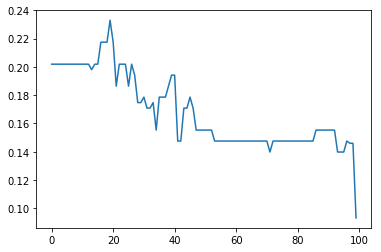

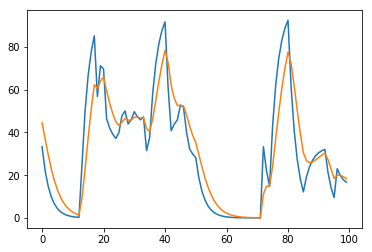

In [6]:
plt.plot(qclose[0:100])
plt.show()
plt.plot(qkdjk[0:100])
plt.plot(qkdjd[0:100])
plt.show()

In [7]:
for i in range(0, len(inputCsvList)):
    input_csv = inputFolderFormat.format(inputCsvList[i])
    data = pd.read_csv(input_csv)
    close = data['Close']
    close = close.fillna(method='ffill')
    close = close.tolist()
    plt.title(inputCsvList[i])
    plt.plot(close)
    plt.show()
    plt.plot(kdallrwdlist[i])
    plt.show()

KeyError: 'Close'

In [ ]:
type(qclose)

In [ ]:
qcom.head(5)

In [ ]:
qcom.columns.values